# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Rescaling
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from PIL import Image
from pathlib import Path
import os
from tqdm import tqdm
import cv2
Mean_IoU = tf.keras.metrics.MeanIoU(num_classes=2)

2022-12-31 10:49:12.517347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 10:49:12.520762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 10:49:12.521456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 10:49:12.522314: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Display an image


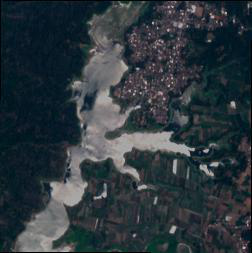

/kaggle/input/water-body-segmentation-in-satellite-images/Water Bodies Dataset Preprocessed/Water Bodies Dataset Preprocessed/Images
Size of the Image (252, 253)



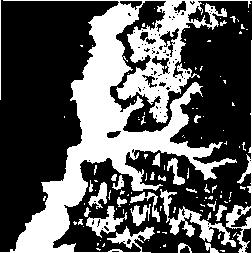

/kaggle/input/water-body-segmentation-in-satellite-images/Water Bodies Dataset Preprocessed/Water Bodies Dataset Preprocessed/Masks
Size of the Image (252, 253)


In [2]:
def display_image(path):# Display a image from test set
    with Image.open(path) as im:
        fig = px.imshow(im)
        fig.update_layout(title=Path(path).stem, width=500)
        fig.show()
        print(os.path.dirname(path))
        images_size = im.size
        print( 'Size of the Image', im.size )
        
display_image(path="/kaggle/input/water-body-segmentation-in-satellite-images/Water Bodies Dataset Preprocessed/Water Bodies Dataset Preprocessed/Images/water_body_10.jpg")
display_image(path="/kaggle/input/water-body-segmentation-in-satellite-images/Water Bodies Dataset Preprocessed/Water Bodies Dataset Preprocessed/Masks/water_body_10.jpg")

# Import Images | Resize | Crop | Reshape | Masking of Masks

In [3]:
images_dir = "/kaggle/input/water-body-segmentation-in-satellite-images/Water Bodies Dataset Preprocessed/Water Bodies Dataset Preprocessed/Images/"
masks_dir = "/kaggle/input/water-body-segmentation-in-satellite-images/Water Bodies Dataset Preprocessed/Water Bodies Dataset Preprocessed/Masks/"

images_filenames = [images_dir + filename for filename in os.listdir(images_dir) ]
masks_filenames = [masks_dir + filename for filename in os.listdir(masks_dir) ]

In [4]:
input_size = 256
output_size = 256
min_pixel, max_pixel = 0,255

In [5]:
def decode_image(image_file_names,size=256, mode="RGB"):
    images = []
    for i in tqdm(range(len(image_file_names))):
        img=Image.open(image_file_names[i])
        if mode == "BW":
            img = img.convert("L")
            width, height = img.size
            left = width/15
            top = height / 15
            right = 14*width/15
            bottom = 14 * height / 15
            img = img.crop((left, top, right, bottom))
            img = np.array(img)
            img = cv2.threshold(img, int((max_pixel+min_pixel)/2) , 1, cv2.THRESH_BINARY)[1]
            img = cv2.resize(img,dsize=(size,size))
            img = np.reshape(img,[img.shape[0],img.shape[1],1])
            
        else:
            width, height = img.size
            left = width/15
            top = height / 15
            right = 14*width/15
            bottom = 14 * height / 15
            img = img.crop((left, top, right, bottom))
            img = np.array(img)
            img = cv2.resize(img,dsize=(size,size))
            img = np.reshape(img,[img.shape[0],img.shape[1],3])
            
        img=np.array(img)
        images.append(img)
        #print(img.shape)
    print('Done --')
    return  np.stack(images, axis=0)

In [6]:
images = decode_image(images_filenames, size=input_size )
masks = decode_image(masks_filenames, size=output_size, mode = "BW" )

100%|██████████| 2494/2494 [00:28<00:00, 87.62it/s] 


Done --


100%|██████████| 2494/2494 [00:20<00:00, 120.89it/s]

Done --


In [7]:
masks.shape, images.shape

((2494, 256, 256, 1), (2494, 256, 256, 3))

<class 'numpy.ndarray'> (256, 256, 3)


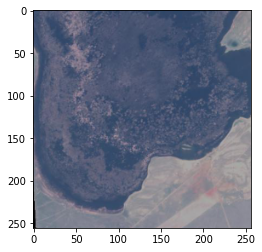

<class 'numpy.ndarray'> (256, 256, 1)


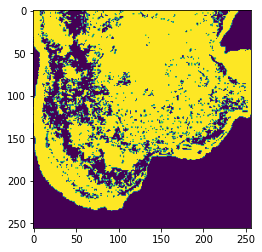

-------------------------------------------------------------
<class 'numpy.ndarray'> (256, 256, 3)


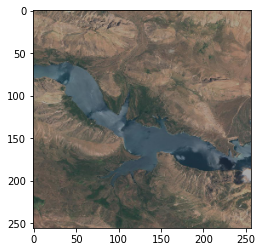

<class 'numpy.ndarray'> (256, 256, 1)


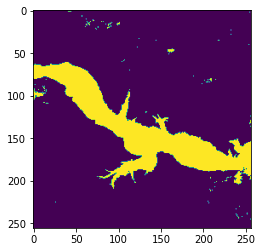

-------------------------------------------------------------
<class 'numpy.ndarray'> (256, 256, 3)


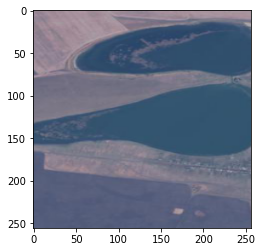

<class 'numpy.ndarray'> (256, 256, 1)


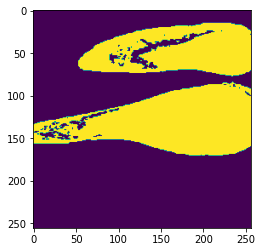

-------------------------------------------------------------


In [8]:
for i in range(3):
    print(type(images[i]),images[i].shape)
    plt.imshow(images[i])
    plt.show()
    print(type(masks[i]),masks[i].shape)
    plt.imshow(masks[i])
    plt.show()
    print("-------------------------------------------------------------")

In [9]:
def load_img_with_mask(image_path, images_dir: str = 'Images', masks_dir: str = 'Masks',images_extension: str = 'jpg', masks_extension: str = 'jpg') -> dict:
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # image = tf.reshape(image,tf.constant((-1,256,256,3)))
    image = tf.image.central_crop(image, central_fraction=0.95)
    image = tf.image.resize(image, size=[256,256])
    
    
    mask_filename = tf.strings.regex_replace(image_path, images_dir, masks_dir)
    mask_filename = tf.strings.regex_replace(mask_filename, images_extension, masks_extension)
    mask = tf.io.read_file(mask_filename)
    mask = tf.image.decode_image(mask, channels=1, expand_animations = False)
    # mask = tf.reshape(mask,tf.constant((-1,256,256,1)))    
    mask = tf.image.central_crop(mask, central_fraction=0.95)
    mask = tf.image.resize(mask, size=[256,256])
    mask = tf.where(mask>int((max_pixel+min_pixel)/2),1,0)
    return (image, mask)

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 10
AUTOTUNE = tf.data.AUTOTUNE

dataset = tf.data.Dataset.list_files("/kaggle/input/water-body-segmentation-in-satellite-images/Water Bodies Dataset Preprocessed/Water Bodies Dataset Preprocessed/Images" + '/*.jpg', seed=10)
test_set_size = 94
validation_set_size = 400 

test_dataset = dataset.take(test_set_size)
dataset = dataset.skip(test_set_size)
test_dataset = test_dataset.map(load_img_with_mask)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

validation_dataset = dataset.take(validation_set_size)
train_dataset = dataset.skip(validation_set_size)
validation_dataset = validation_dataset.map(load_img_with_mask)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_dataset = train_dataset.map(load_img_with_mask)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Creating U-Net Architure using Tensorflow | Training Model

In [10]:
model = Sequential()
model.add( keras.layers.Input(shape=(None,None,3)))
# model.add( tf.keras.layers.Resizing(input_size,input_size))
# model.add( tf.keras.layers.Rescaling( 1./255 ))
          
model.add( Conv2D( filters=64, kernel_size=(3,3), padding='same', activation='relu') )
model.add( Conv2D( filters=64, kernel_size=(3,3), padding='same', activation='relu') )
model.add( BatchNormalization() )
model.add( MaxPooling2D(pool_size=(2,2),strides=2))
            
model.add( Conv2D( filters=128, kernel_size=(3,3), padding='same', activation='relu') )
model.add( Conv2D( filters=128, kernel_size=(3,3), padding='same', activation='relu') )
model.add( BatchNormalization() )
model.add( MaxPooling2D(pool_size=(2,2),strides=(2,2) ))

model.add( Conv2D( filters=256, kernel_size=(3,3), padding='same', activation='relu') )
model.add( Conv2D( filters=256, kernel_size=(3,3), padding='same', activation='relu') )
model.add( BatchNormalization() )
model.add( MaxPooling2D(pool_size=(2,2),strides=2) )
          
model.add( Conv2D( filters=512, kernel_size=(3,3), padding='same', activation='relu') )
model.add( Conv2D( filters=512, kernel_size=(3,3), padding='same', activation='relu') )
model.add( BatchNormalization() )
model.add( MaxPooling2D(pool_size=(2,2),strides=2) )
          
model.add( Conv2D( filters=1024, kernel_size=(3,3), padding='same', activation='relu') )
model.add( Conv2D( filters=1024, kernel_size=(3,3), padding='same', activation='relu') )
model.add( BatchNormalization() )
model.add( UpSampling2D(size=(2,2)) )

model.add( Conv2D( filters=512, kernel_size=(3,3), padding='same', activation='relu') )
model.add( Conv2D( filters=512, kernel_size=(3,3), padding='same', activation='relu') )
model.add( BatchNormalization() )
model.add( UpSampling2D(size=(2,2)) )

model.add( Conv2D( filters=256, kernel_size=(3,3), padding='same', activation='relu') )
model.add( Conv2D( filters=256, kernel_size=(3,3), padding='same', activation='relu') )
model.add( BatchNormalization() )
model.add( UpSampling2D(size=(2,2)) )

model.add( Conv2D( filters=128, kernel_size=(3,3), padding='same', activation='relu') )
model.add( Conv2D( filters=128, kernel_size=(3,3), padding='same', activation='relu') )
model.add( BatchNormalization() )
model.add( UpSampling2D(size=(2,2)) )

model.add( Conv2D( filters=64, kernel_size=(3,3), padding='same', activation='relu') )
model.add( Conv2D( filters=64, kernel_size=(3,3), padding='same', activation='relu') )
model.add( BatchNormalization() )

model.add( Conv2D( filters=1, kernel_size=(1,1), padding='same', activation='sigmoid') )

model.compile( optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy())
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 64)    1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
batch_normalization (BatchNo (None, None, None, 64)    256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 128)   73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 128)   147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 128)   5

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
MCP = tf.keras.callbacks.ModelCheckpoint("/kaggle/working/model/", save_best_only=True)
history = model.fit( train_dataset, validation_data=validation_dataset , epochs=50,callbacks=[early_stopping,MCP,lr_reduce],batch_size=BATCH_SIZE) 

Epoch 1/50


2022-12-31 10:50:08.206342: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-31 10:50:10.845301: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


63/63 [==============================] - 67s 789ms/step - loss: 0.5472 - val_loss: 8.5651


2022-12-31 10:51:17.176471: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/50
63/63 [==============================] - 44s 688ms/step - loss: 0.4217 - val_loss: 9.3356
Epoch 3/50
63/63 [==============================] - 44s 693ms/step - loss: 0.3847 - val_loss: 2.1477
Epoch 4/50
63/63 [==============================] - 43s 688ms/step - loss: 0.3477 - val_loss: 1.7472
Epoch 5/50
63/63 [==============================] - 44s 692ms/step - loss: 0.3187 - val_loss: 0.6230
Epoch 6/50
63/63 [==============================] - 44s 690ms/step - loss: 0.3141 - val_loss: 0.7647
Epoch 7/50
63/63 [==============================] - 44s 689ms/step - loss: 0.2991 - val_loss: 2.1108
Epoch 8/50
63/63 [==============================] - 43s 688ms/step - loss: 0.2878 - val_loss: 0.6756
Epoch 9/50
63/63 [==============================] - 43s 687ms/step - loss: 0.2912 - val_loss: 0.7184
Epoch 10/50
63/63 [==============================] - 44s 688ms/step - loss: 0.2747 - val_loss: 0.3230
Epoch 11/50
63/63 [==============================] - 46s 729ms/step - loss: 0.2649 - val_l

In [12]:
model.save('image_segmentation_model_UNet.h5')

# Loss vs epochs graph


In [13]:
def Plot_Loss_Accuracy( history, epochs ):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = np.linspace(1,epochs,epochs)
    epochs
    fig = go.Figure(data=go.Scatter( x=epochs, y=loss, name='loss' ))
    fig.add_trace( go.Scatter( x=epochs, y=val_loss, name='val_loss' ) )
    fig.update_layout( title="Loss", xaxis_title='epochs' )
    fig.show()
    
Plot_Loss_Accuracy( history, epochs=50 )

# Predicted Segmented Images

In [14]:
model = tf.keras.models.load_model('/kaggle/working/image_segmentation_model_UNet.h5')

In [15]:
for data in test_dataset.take(test_set_size):
    images, masks = data[0].numpy(), data[1].numpy()
    preds =  tf.where(model.predict(images) > 0.5, 1, 0)

Original Image (256, 256, 3)



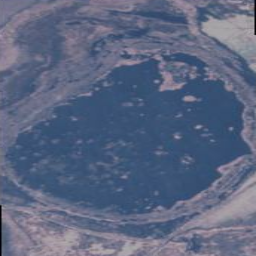

Original Mask   (256, 256, 1)


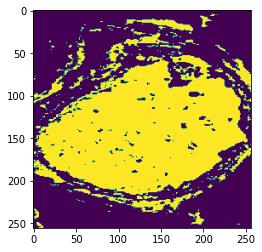

Predicted Mask   (256, 256, 1)


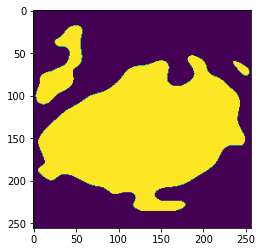

-------------------------------------------------------------


In [16]:
import random
i = random.randint(0,10) # < test_set_size

print( "Original Image" ,images[i].shape)
fig = px.imshow(images[i])
fig.update_layout(width=400, height=400)
fig.show()
print("Original Mask  " ,masks[i].shape)
plt.imshow(masks[i])
plt.show()
print("Predicted Mask  " ,preds[i].shape)
plt.imshow(preds[i])
plt.show()
print("-------------------------------------------------------------")

# IOU - Intersection Over Union Score

In [17]:
for ele in validation_dataset.take(validation_set_size):
    image, y_true = ele
    prediction = model.predict(image)[0]
    prediction = tf.where(prediction > 0.5, 1, 0)
    Mean_IoU.update_state(y_true[0], prediction)
print("Mean IoU Score: ",Mean_IoU.result().numpy())

Mean IoU Score:  0.7494344


In [18]:
for ele in test_dataset.take(test_set_size):
    image, y_true = ele
    prediction = model.predict(image)[0]
    prediction = tf.where(prediction > 0.5, 1, 0)
    Mean_IoU.update_state(y_true[0], prediction)
print("Mean IoU Score: ",Mean_IoU.result().numpy())

Mean IoU Score:  0.7618395


References:

https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

https://www.youtube.com/watch?v=QmCxqsbn5B0&t=71s
